# imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import phik 
from phik.report import plot_correlation_matrix
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score
import optuna

import warnings
warnings.filterwarnings("ignore")

# data loading

In [2]:
df = pd.read_csv('stage_1_classification_train.csv')
df

,temperature_2m,relative_humidity_2m,dew_point_2m,cloud_cover,et0_fao_evapotranspiration,sunshine_duration,shortwave_radiation_instant,target
0,11.872500,94.533066,11.022500,100.0,0.000000,0.0000,0.00000,0
1,16.922499,96.874540,16.422499,100.0,0.000000,0.0000,0.00000,0
2,8.246000,91.830950,6.996000,100.0,0.002607,0.0000,0.00000,0
3,18.196000,81.862130,15.046000,100.0,0.120244,0.0000,195.61572,0
4,16.322498,55.796270,7.472500,0.0,0.060671,0.0000,0.00000,1
...,...,...,...,...,...,...,...,...
16624,0.322500,49.302870,-9.077500,0.0,0.045354,0.0000,0.00000,1
16625,17.046000,69.369064,11.396000,17.1,0.247695,3600.0000,503.61124,0
16626,13.672500,92.766340,12.522500,27.9,0.000000,0.0000,0.00000,1
16627,24.446000,28.287868,4.896000,29.7,0.196661,3600.0000,283.07400,1


In [3]:
pred_df = pd.read_csv('stage_1_classification_test_features.csv', index_col=0)
pred_df

,temperature_2m,relative_humidity_2m,dew_point_2m,cloud_cover,et0_fao_evapotranspiration,sunshine_duration,shortwave_radiation_instant
index,,,,,,,
0,19.2960,46.503178,7.5460,27.000002,0.150875,3600.0000,184.567800
1,20.8960,74.035706,16.0960,31.800001,0.211327,3600.0000,384.852800
2,2.6460,89.843414,1.1460,100.000000,0.002671,0.0000,0.000000
3,7.8725,91.807570,6.6225,36.600000,0.000000,0.0000,0.000000
4,2.0225,84.124054,-0.3775,100.000000,0.002527,0.0000,0.000000
...,...,...,...,...,...,...,...
4153,13.8225,41.254710,0.8725,100.000000,0.199135,3600.0000,349.583650
4154,20.3960,57.198450,11.6460,34.800003,0.298315,3600.0000,377.446040
4155,12.8460,81.441060,9.7460,26.400002,0.049897,3035.8867,115.651184


# data analysis

In [4]:
df.isna().sum().sum()

0

In [5]:
df.columns

Index(['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'cloud_cover',
       'et0_fao_evapotranspiration', 'sunshine_duration',
       'shortwave_radiation_instant', 'target'],
      dtype='object')

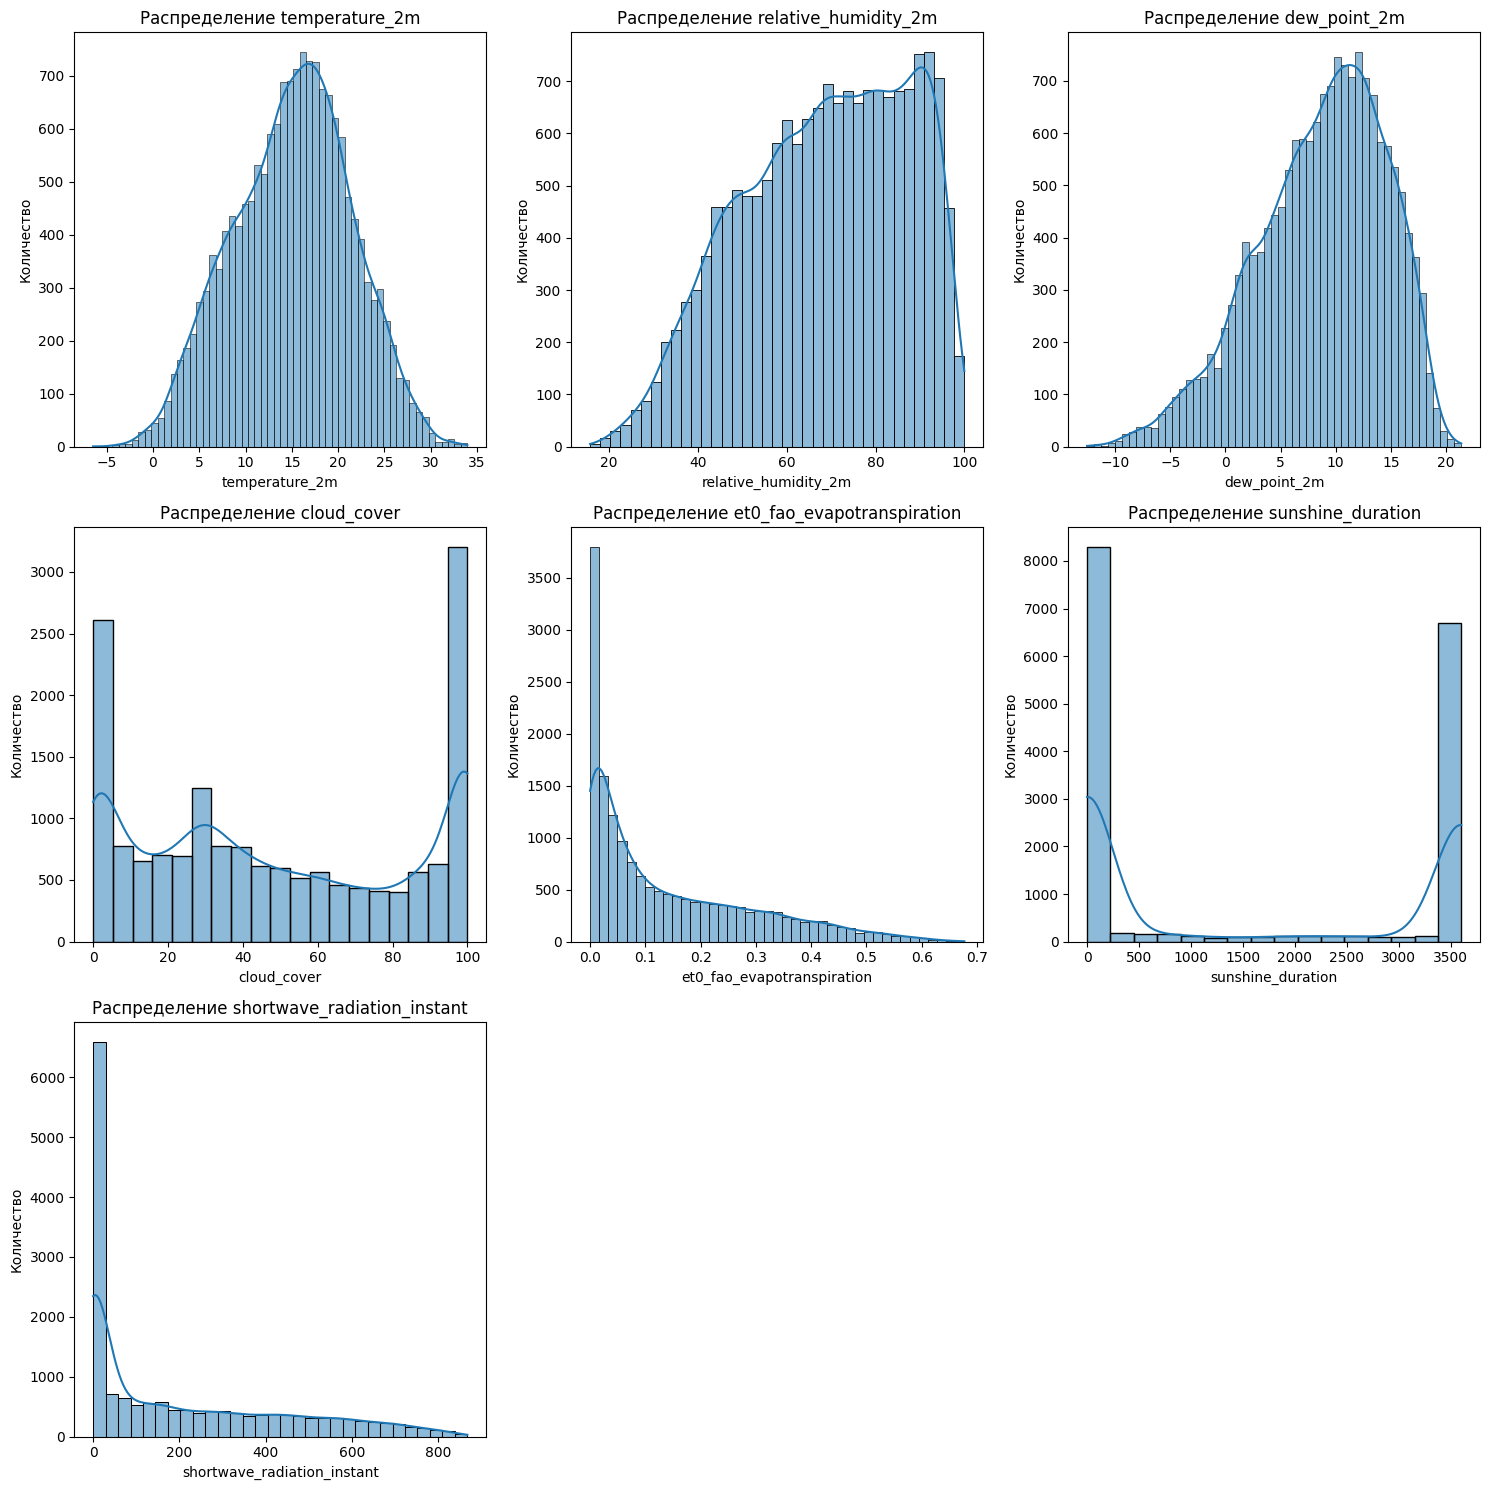

In [6]:
# визуализация распределения признаков
def visualize_distributions(df, numeric_only=True):
    """
    Визуализирует распределение признаков в DataFrame.

    Args:
        df (pd.DataFrame): DataFrame с данными.
        numeric_only (bool, optional): Визуализировать только числовые признаки. По умолчанию True.
    """

    if numeric_only:
        numeric_cols = df.select_dtypes(include=['number']).columns
    else:
        numeric_cols = df.columns
    
    if len(numeric_cols) == 0:
      print("Нет числовых признаков для визуализации.")
      return
    
    num_cols = len(numeric_cols)
    num_rows = (num_cols + 2) // 3  # Определяем количество строк для подграфиков

    plt.figure(figsize=(15, 5 * num_rows)) # Делаем размеры рисунка побольше

    for i, column in enumerate(numeric_cols, 1):
        plt.subplot(num_rows, 3, i) # Создаем подграфик на каждой итерации
        sns.histplot(df[column], kde=True)  # Гистограмма с KDE (оценка плотности ядра)
        plt.title(f'Распределение {column}') # Выводим заголовок к графику
        plt.xlabel(column) # Выводим название оси Х
        plt.ylabel("Количество") # Выводим название оси Y

    plt.tight_layout()  # Автоматически регулирует расположение графиков
    plt.show()


# Визуализируем распределения числовых признаков
visualize_distributions(df.drop(columns=['target']))

In [7]:
# # применение логарифмирования для признаков с плохим распределением
# bad_list = ['cloud_cover',
#        'et0_fao_evapotranspiration', 'sunshine_duration',
#        'shortwave_radiation_instant']

# for col in tqdm(bad_list):
#     df[col] = df[col].apply(lambda x: np.log10(x + 1))

# visualize_distributions(df.drop(columns=['target']))

interval columns not set, guessing: ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'cloud_cover', 'et0_fao_evapotranspiration', 'sunshine_duration', 'shortwave_radiation_instant', 'target']


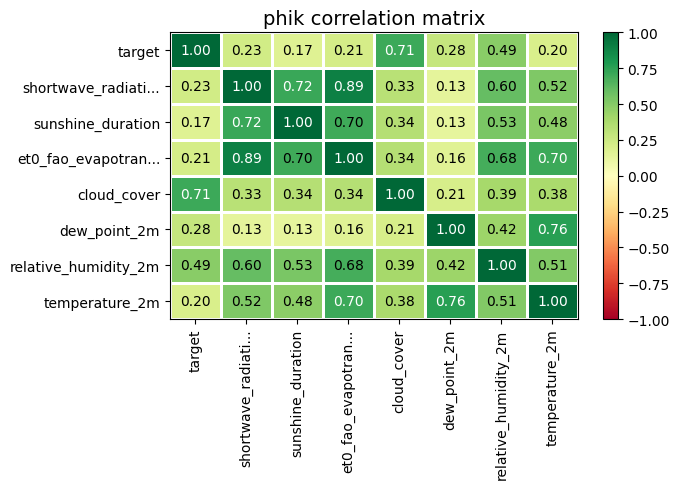

In [8]:
phik_matrix = df.phik_matrix()

plot_correlation_matrix(phik_matrix.values,
                        x_labels = phik_matrix.columns,
                        y_labels = phik_matrix.index,
                        title = 'phik correlation matrix'
)

In [9]:
df.drop(columns = ['et0_fao_evapotranspiration'], inplace = True)
df

,temperature_2m,relative_humidity_2m,dew_point_2m,cloud_cover,sunshine_duration,shortwave_radiation_instant,target
0,11.872500,94.533066,11.022500,100.0,0.0000,0.00000,0
1,16.922499,96.874540,16.422499,100.0,0.0000,0.00000,0
2,8.246000,91.830950,6.996000,100.0,0.0000,0.00000,0
3,18.196000,81.862130,15.046000,100.0,0.0000,195.61572,0
4,16.322498,55.796270,7.472500,0.0,0.0000,0.00000,1
...,...,...,...,...,...,...,...
16624,0.322500,49.302870,-9.077500,0.0,0.0000,0.00000,1
16625,17.046000,69.369064,11.396000,17.1,3600.0000,503.61124,0
16626,13.672500,92.766340,12.522500,27.9,0.0000,0.00000,1
16627,24.446000,28.287868,4.896000,29.7,3600.0000,283.07400,1


interval columns not set, guessing: ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'cloud_cover', 'sunshine_duration', 'shortwave_radiation_instant']


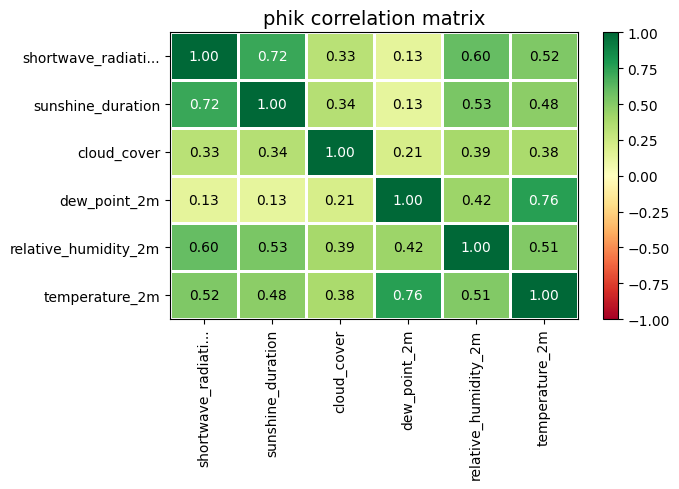

In [10]:
phik_matrix = df.drop(columns=['target']).phik_matrix()

plot_correlation_matrix(phik_matrix.values,
                        x_labels = phik_matrix.columns,
                        y_labels = phik_matrix.index,
                        title = 'phik correlation matrix'
)

# data to training dataset

In [11]:
X = df.drop(columns = ['target'])
X

,temperature_2m,relative_humidity_2m,dew_point_2m,cloud_cover,sunshine_duration,shortwave_radiation_instant
0,11.872500,94.533066,11.022500,100.0,0.0000,0.00000
1,16.922499,96.874540,16.422499,100.0,0.0000,0.00000
2,8.246000,91.830950,6.996000,100.0,0.0000,0.00000
3,18.196000,81.862130,15.046000,100.0,0.0000,195.61572
4,16.322498,55.796270,7.472500,0.0,0.0000,0.00000
...,...,...,...,...,...,...
16624,0.322500,49.302870,-9.077500,0.0,0.0000,0.00000
16625,17.046000,69.369064,11.396000,17.1,3600.0000,503.61124
16626,13.672500,92.766340,12.522500,27.9,0.0000,0.00000
16627,24.446000,28.287868,4.896000,29.7,3600.0000,283.07400


In [12]:
y = df.target
y

0        0
1        0
2        0
3        0
4        1
        ..
16624    1
16625    0
16626    1
16627    1
16628    0
Name: target, Length: 16629, dtype: int64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y)

# catboost + optuna

In [14]:
# Функция для оценки модели с заданными гиперпараметрами
def objective(trial):
    # Определение пространства поиска гиперпараметров
    params = {
        'iterations': trial.suggest_int('iterations', 100, 3000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 2, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 100.0),
        # 'border_count': trial.suggest_int('border_count', 32, 255),
        # 'random_strength': trial.suggest_uniform('random_strength', 0.5, 50),
        # 'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 10.0),
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        # 'max_leaves': trial.suggest_int('max_leaves', 2, 64) if params['grow_policy'] == 'Lossguide' else None,
        # 'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
        'task_type': 'CPU',  # Или 'GPU', если вы хотите использовать GPU
        'verbose': 0,
        'random_seed': 1001
    }

    # Создание и обучение модели
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    
    # Кросс-валидация для оценки качества модели
    # scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    scores = accuracy_score(y_test, model.predict(X_test))
    
    # Возвращаем среднее значение метрики (accuracy) для кросс-валидации
    return scores
    # return scores.mean()

In [15]:
# Создание объекта исследования
study = optuna.create_study(direction='maximize')

[I 2024-12-15 23:36:32,738] A new study created in memory with name: no-name-36e00b07-5a04-44c7-9b8e-6069e32ce67c


In [16]:
# Запуск оптимизации
study.optimize(objective, n_trials=100)

[I 2024-12-15 23:37:21,030] Trial 0 finished with value: 0.8370414912808178 and parameters: {'iterations': 1128, 'learning_rate': 0.010782977442294717, 'depth': 10, 'l2_leaf_reg': 1.2228941317059494e-05}. Best is trial 0 with value: 0.8370414912808178.
[I 2024-12-15 23:37:23,512] Trial 1 finished with value: 0.8346361996392062 and parameters: {'iterations': 438, 'learning_rate': 0.09075956560125253, 'depth': 6, 'l2_leaf_reg': 13.649257030264222}. Best is trial 0 with value: 0.8370414912808178.
[I 2024-12-15 23:37:26,161] Trial 2 finished with value: 0.8400481058328322 and parameters: {'iterations': 771, 'learning_rate': 0.0686776156545945, 'depth': 3, 'l2_leaf_reg': 0.000253494346606778}. Best is trial 2 with value: 0.8400481058328322.
[I 2024-12-15 23:37:36,998] Trial 3 finished with value: 0.8214070956103428 and parameters: {'iterations': 2059, 'learning_rate': 0.12641280939272356, 'depth': 6, 'l2_leaf_reg': 2.4637791737945297e-05}. Best is trial 2 with value: 0.8400481058328322.
[I 

In [17]:
study.best_params

{'iterations': 1570,
 'learning_rate': 0.019525886909604145,
 'depth': 2,
 'l2_leaf_reg': 8.439631480493157e-06}

In [18]:
# Обучение финальной модели с лучшими гиперпараметрами
best_params = study.best_params
best_model = CatBoostClassifier(**best_params, verbose=52)
best_model.fit(X_train, y_train)

0:	learn: 0.6828038	total: 5.57ms	remaining: 8.74s
52:	learn: 0.4704864	total: 220ms	remaining: 6.3s
104:	learn: 0.4241983	total: 412ms	remaining: 5.75s
156:	learn: 0.4053174	total: 593ms	remaining: 5.34s
208:	learn: 0.3953182	total: 771ms	remaining: 5.02s
260:	learn: 0.3890482	total: 949ms	remaining: 4.76s
312:	learn: 0.3844448	total: 1.13s	remaining: 4.54s
364:	learn: 0.3806191	total: 1.32s	remaining: 4.36s
416:	learn: 0.3778038	total: 1.5s	remaining: 4.16s
468:	learn: 0.3754626	total: 1.68s	remaining: 3.94s
520:	learn: 0.3733895	total: 1.86s	remaining: 3.74s
572:	learn: 0.3715068	total: 2.03s	remaining: 3.54s
624:	learn: 0.3699952	total: 2.21s	remaining: 3.35s
676:	learn: 0.3686492	total: 2.39s	remaining: 3.15s
728:	learn: 0.3673990	total: 2.56s	remaining: 2.96s
780:	learn: 0.3663711	total: 2.74s	remaining: 2.77s
832:	learn: 0.3654295	total: 2.92s	remaining: 2.58s
884:	learn: 0.3646133	total: 3.1s	remaining: 2.4s
936:	learn: 0.3638891	total: 3.29s	remaining: 2.22s
988:	learn: 0.3631

# predict

In [19]:
pred_df.drop(columns = ['et0_fao_evapotranspiration'], inplace = True)
pred_df

,temperature_2m,relative_humidity_2m,dew_point_2m,cloud_cover,sunshine_duration,shortwave_radiation_instant
index,,,,,,
0,19.2960,46.503178,7.5460,27.000002,3600.0000,184.567800
1,20.8960,74.035706,16.0960,31.800001,3600.0000,384.852800
2,2.6460,89.843414,1.1460,100.000000,0.0000,0.000000
3,7.8725,91.807570,6.6225,36.600000,0.0000,0.000000
4,2.0225,84.124054,-0.3775,100.000000,0.0000,0.000000
...,...,...,...,...,...,...
4153,13.8225,41.254710,0.8725,100.000000,3600.0000,349.583650
4154,20.3960,57.198450,11.6460,34.800003,3600.0000,377.446040
4155,12.8460,81.441060,9.7460,26.400002,3035.8867,115.651184


In [20]:
pred = best_model.predict(pred_df)
pred

array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [21]:
pred_df['target'] = pred
pred_df

,temperature_2m,relative_humidity_2m,dew_point_2m,cloud_cover,sunshine_duration,shortwave_radiation_instant,target
index,,,,,,,
0,19.2960,46.503178,7.5460,27.000002,3600.0000,184.567800,1
1,20.8960,74.035706,16.0960,31.800001,3600.0000,384.852800,0
2,2.6460,89.843414,1.1460,100.000000,0.0000,0.000000,0
3,7.8725,91.807570,6.6225,36.600000,0.0000,0.000000,1
4,2.0225,84.124054,-0.3775,100.000000,0.0000,0.000000,0
...,...,...,...,...,...,...,...
4153,13.8225,41.254710,0.8725,100.000000,3600.0000,349.583650,1
4154,20.3960,57.198450,11.6460,34.800003,3600.0000,377.446040,1
4155,12.8460,81.441060,9.7460,26.400002,3035.8867,115.651184,1


In [22]:
pred_df.drop(columns = list(pred_df.columns.drop('target')), inplace = True)
pred_df

,target
index,
0,1
1,0
2,0
3,1
4,0
...,...
4153,1
4154,1
4155,1


In [23]:
pred_df.to_csv('sub.csv')